In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# !! INPUT PATH will be changed
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/test-to-delete/test.json
/kaggle/input/bankdefaultsinrussia/dataset.csv
/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv
/kaggle/input/sber-price-hist/---.-ru0009029540.xlsx


# 1. Russian banks' defaults Dataset
- for classic ML model
- for prediction of default and usage its probability as feature

In [2]:
df = pd.read_csv('/data/banks_data/dataset.csv')
df = df.dropna().reset_index(drop=True)
df['дата'] = pd.to_datetime(df['дата'])
df = df.astype({'лицензия': 'int', 'default': 'int', 'msk_spb': 'int'})
#        .astype({'лицензия': 'object', 'default': 'object', 'msk_spb': 'object'})
df = df.rename(columns={'лицензия': 'licence_num', 'дата': 'date'})  # .drop(columns=['дата'])

In [3]:
# feature engineering
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = pd.DatetimeIndex(df['date']).dayofweek
df['yearmonth'] = df.apply(lambda row: 100 * row['year'] + row['month'], axis = 1)

df['n_reports'] = df.groupby('licence_num')['licence_num'].transform('count')
df['occurence'] = df.groupby(['licence_num']).cumcount()+1

In [4]:
print('total number of observations:  ', len(df))
print('total number of banks:         ', len(df.licence_num.unique()))
print('total number of default cases: ', df.default[df.default == 1].count())

total number of observations:   70483
total number of banks:          1006
total number of default cases:  373


In [5]:
df.describe(include='all')

,licence_num,date,net_assets,ROA,liquid,ibl,stocks,bond,oth_cap,sunk_retail_credit,...,i_retail_spread_diff,usd_rub_return,miacr_diff,default,month,year,day_of_week,yearmonth,n_reports,occurence
count,70483.000000,70483,7.048300e+04,70483.000000,7.048300e+04,7.048300e+04,7.048300e+04,7.048300e+04,7.048300e+04,7.048300e+04,...,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000
mean,2127.323241,2013-10-22 01:31:26.803910400,7.236481e+07,122.509414,5.012372e+06,7.697896e+06,6.666620e+05,8.128531e+06,1.789404e+06,6.694933e+05,...,-0.034402,0.009303,0.080183,0.005292,6.511655,2013.348737,3.028049,201341.385313,79.551736,40.275868
min,0.000000,2010-02-01 00:00:00,0.000000e+00,-64556.000000,0.000000e+00,0.000000e+00,-1.223600e+04,0.000000e+00,0.000000e+00,0.000000e+00,...,-25.940000,-0.118357,-1.848351,0.000000,1.000000,2010.000000,0.000000,201002.000000,1.000000,1.000000
25%,1222.000000,2012-01-01 00:00:00,1.288528e+06,14.000000,1.880120e+05,1.587500e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.730000e+02,...,-0.580000,-0.015871,-0.213459,0.000000,3.000000,2012.000000,1.000000,201201.000000,71.000000,19.000000
50%,2388.000000,2013-09-01 00:00:00,3.634798e+06,91.000000,4.904740e+05,1.770360e+05,0.000000e+00,6.046600e+04,0.000000e+00,8.633000e+03,...,-0.100000,-0.001414,0.021180,0.000000,6.000000,2013.000000,3.000000,201309.000000,87.000000,38.000000
75%,3013.000000,2015-07-01 00:00:00,1.363160e+07,214.000000,1.467784e+06,8.002580e+05,1.601100e+04,1.099926e+06,6.800000e+01,5.926050e+04,...,0.300000,0.026706,0.193273,0.000000,10.000000,2015.000000,5.000000,201507.000000,94.000000,60.000000
max,3481.000000,2017-12-01 00:00:00,2.377734e+10,76314.000000,1.814549e+09,2.058386e+09,2.559021e+08,2.453111e+09,9.821342e+08,1.770647e+08,...,16.750000,0.206696,5.257585,1.000000,12.000000,2017.000000,6.000000,201712.000000,95.000000,95.000000
std,1024.225345,NaN,7.128239e+08,932.385773,4.456060e+07,6.603335e+07,5.726575e+06,7.491471e+07,2.863922e+07,5.535170e+06,...,4.092392,0.049228,0.817419,0.072554,3.457549,2.126181,2.003309,212.431594,17.871872,25.174696


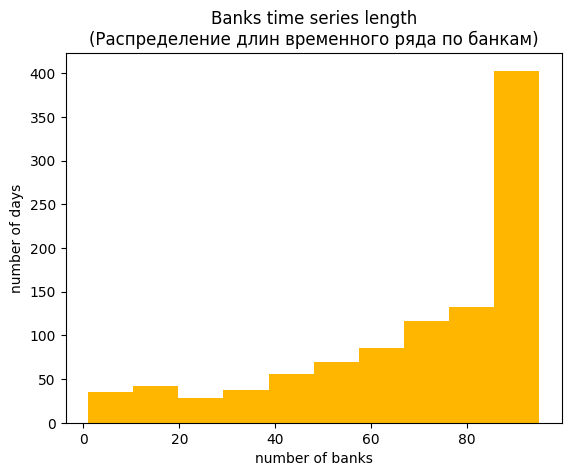

In [6]:
df.groupby('licence_num').agg({'date': 'count'}).hist(grid=False, color='#ffb600')
plt.xlabel('number of banks')
plt.ylabel('number of days')
plt.title('Banks time series length\n(Распределение длин временного ряда по банкам)');

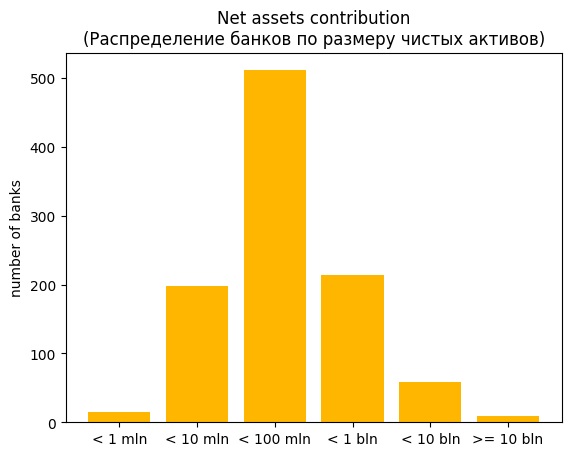

In [7]:
df_last = df.groupby('licence_num').last()

condlist = [
    (df_last.net_assets < 1e5),
    (df_last.net_assets >= 1e5) & (df_last.net_assets < 1e6),
    (df_last.net_assets >= 1e6) & (df_last.net_assets < 1e7),
    (df_last.net_assets >= 1e7) & (df_last.net_assets < 1e8),
    (df_last.net_assets >= 1e8) & (df_last.net_assets < 1e9),
    (df_last.net_assets >= 1e9)
]
choicelist = ['< 1 mln', '< 10 mln', '< 100 mln',
              '< 1 bln', '< 10 bln', '>= 10 bln']
df_last['net_assets_category'] = np.select(condlist=condlist, choicelist=choicelist)

bar_data = df_last.groupby('net_assets_category').agg({'date': 'count'}).reindex(choicelist)
plt.bar(bar_data.index, height=bar_data['date'], color='#ffb600')
plt.ylabel('number of banks')
plt.title('Net assets contribution\n(Распределение банков по размеру чистых активов)');

In [8]:
df_date_count = df.loc[df['default'] == 1]\
                  .groupby('date')\
                  .agg({'net_assets': 'sum', 'default': 'sum'})\
                  .reset_index()
df_date_count = pd.DataFrame(df['date'].drop_duplicates()).merge(df_date_count, how='left', on='date').fillna(0)


fig = px.scatter(df_date_count, x="date", y="default", size='net_assets',
                 color_discrete_sequence=['black'],
                 title='Defaults Distribution in time (Распределение дефолтов по времени)')\
        .update_layout(xaxis_title="date (bubble size - sum of default banks' net assets )", yaxis_title="number of defaults")
# fig.
fig.show()

In [11]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix of Default Dataset', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

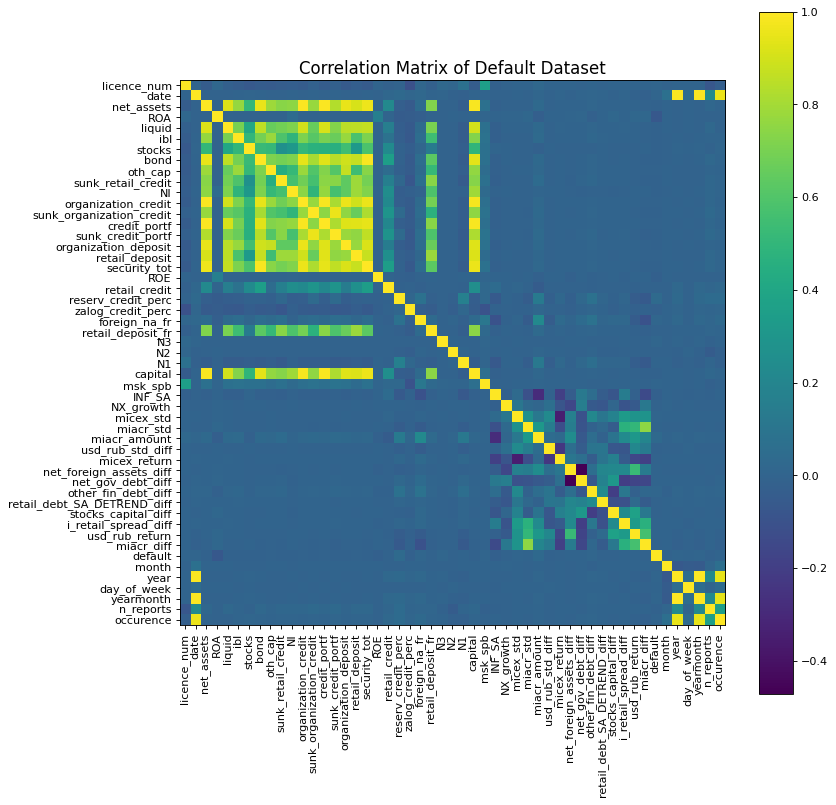

In [12]:
plotCorrelationMatrix(df, 11)

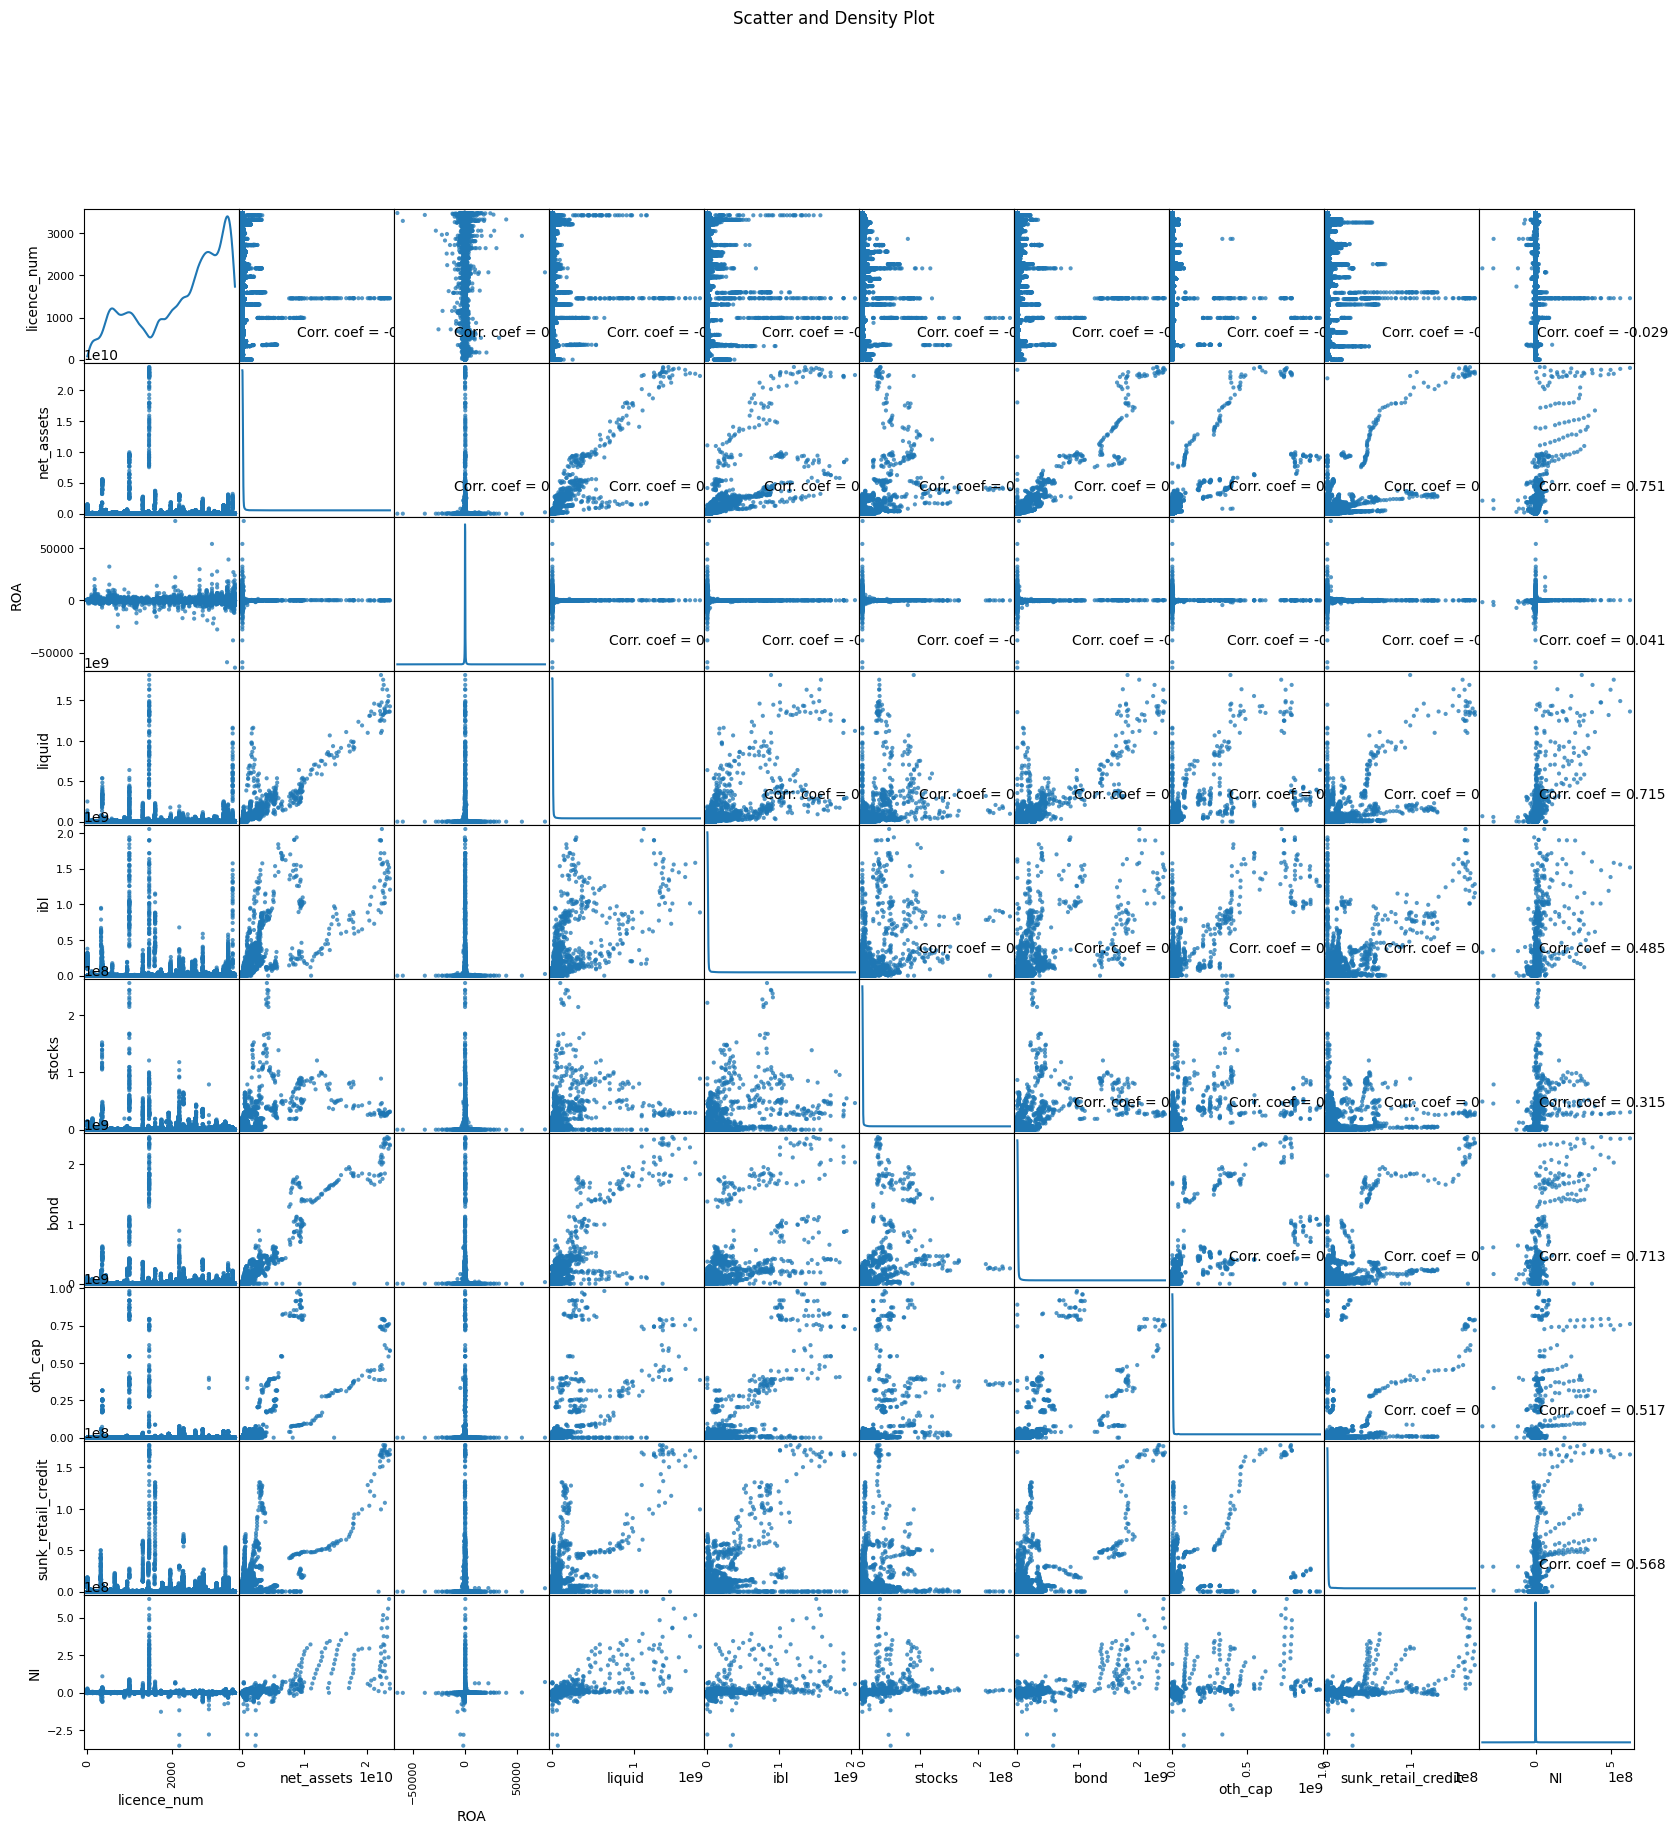

In [ ]:
plotScatterMatrix(df, 20, 10)

# 2. News Dataset
- Data with time range from 2010 to 2017
- From lenta.ru

In [ ]:
# lenta-ru-news.csv has 739351 rows in reality, but we filter news later 2010
df1 = pd.read_csv('/data/news/lenta-ru-news.csv', delimiter=',')
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.loc[(df1['date'] >= '2009-12-01') &
              (df1['date'] <= '2017-12-01')].reset_index(drop=True)

df1['sym_len'] = df1.title.apply(len)
df1['word_len'] = df1.title.apply(lambda x: len(x.split()))

df1 = df1[df1['topic'].isin(['Экономика', 'Мир', 'Россия'])]
# df1.to_csv('lenta-ru-news-2010-to-2017.csv', index=False)

/tmp/ipykernel_33/2364941606.py:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



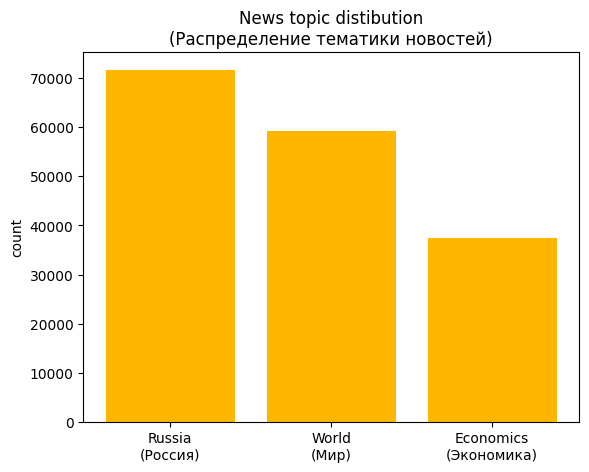

In [ ]:
data_topic_dist = df1.topic.value_counts().reset_index()
topic_dict = {'Россия': 'Russia\n(Россия)', 'Мир': 'World\n(Мир)', 'Экономика': 'Economics\n(Экономика)'}
data_topic_dist = data_topic_dist.replace({"topic": topic_dict})
plt.bar(data_topic_dist['topic'], height=data_topic_dist['count'], color='#ffb600')
plt.ylabel('number of news')
plt.title('News topic distibution\n(Распределение тематики новостей)');

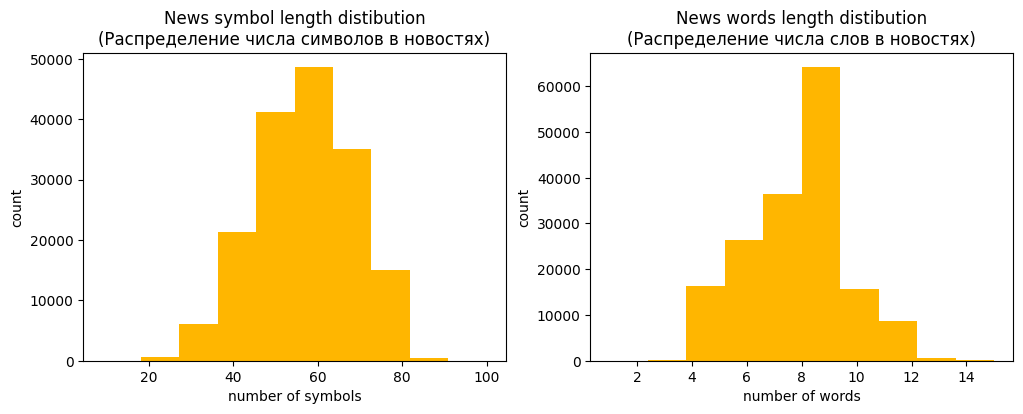

In [ ]:
fig = plt.figure(figsize =(12, 4))

plt.subplot(1, 2, 1)
df1.sym_len.hist(grid=False, color='#ffb600')
plt.xlabel('number of symbols')
plt.ylabel('count')
plt.title('News symbol length distibution\n(Распределение числа символов в новостях)')

plt.subplot(1, 2, 2)
df1.word_len.hist(grid=False, color='#ffb600')
plt.xlabel('number of words')
plt.ylabel('count')
plt.title('News words length distibution\n(Распределение числа слов в новостях)')

plt.show();

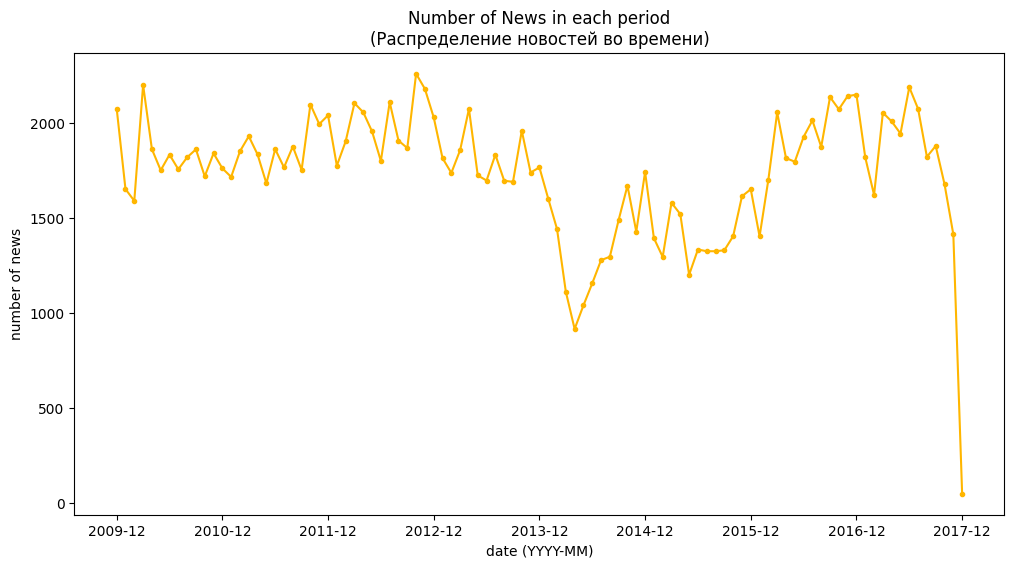

In [ ]:
fig = plt.figure(figsize =(12, 6))

df_news_time = df1.groupby(by=[df1.date.dt.year, df1.date.dt.month]).agg({'title': 'count'})
df_news_time.index.names = ['year', 'month']
df_news_time = df_news_time.reset_index()
df_news_time['year-month'] = df_news_time['year'].astype(str) + '-' + df_news_time['month'].astype(str)

plt.plot(df_news_time['year-month'], df_news_time['title'], color='#ffb600', marker='.')
plt.xlabel('date (YYYY-MM)')
plt.ylabel('number of news')
plt.xticks(df_news_time['year-month'][::12])
plt.title('Number of News in each period\n(Распределение новостей во времени)');

# 3. Stocks price timeseries
- MOEX (Moscow Exchange) tickers of stocks: SBER, VTBR, BSPB
- use stock price as target that is liquid enough

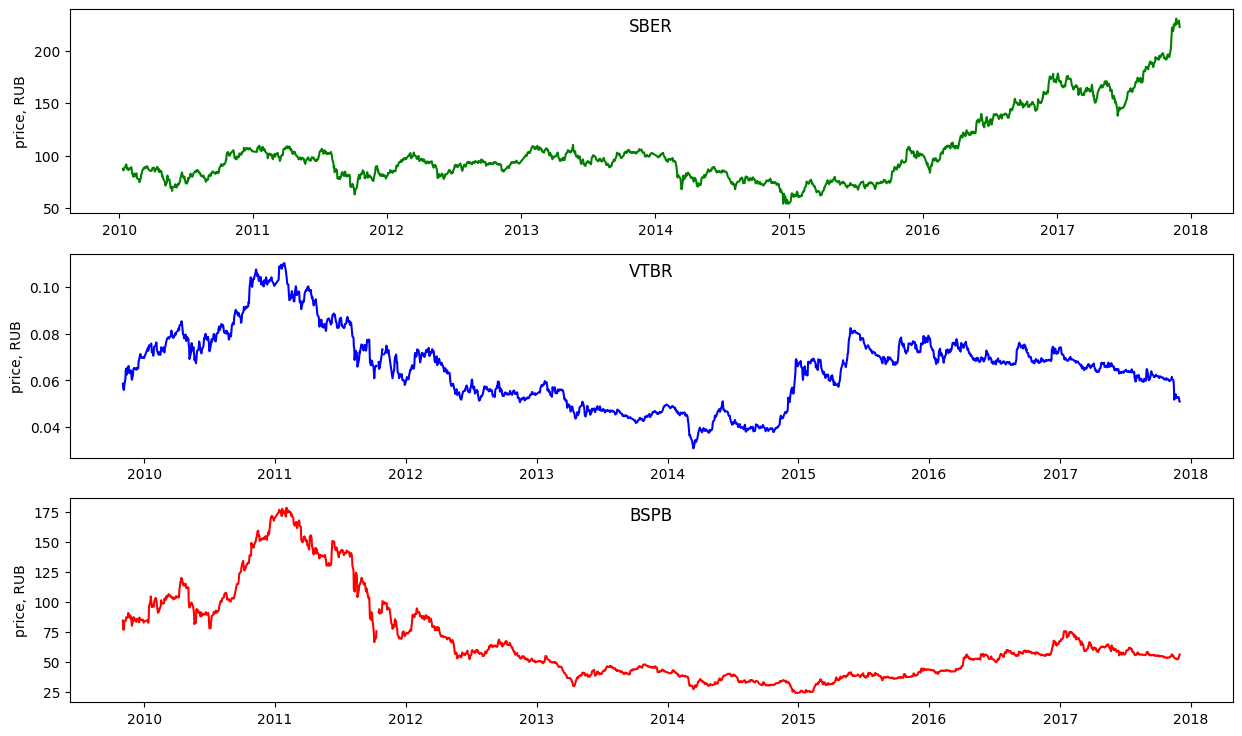

In [37]:
def filter_stock_time_series(data):
    return data.loc[(data['Дата'] >= '2009-11-01') &
                    (data['Дата'] <= '2017-12-01')]

def build_stocks_plot(filenames_colors_dict):
    fig = plt.figure(figsize =(15, 9))

    for i, filename in enumerate(filenames_colors_dict.keys()):
        df_stock = pd.read_excel('/data/stocks/'+filename, header=1)
        df_stock = filter_stock_time_series(df_stock)

        plt.subplot(len(filenames_colors_dict), 1, i+1)
        plt.plot(df_stock['Дата'], df_stock['Avg'], color=filenames_colors_dict[filename])
        plt.ylabel('price, RUB')
        plt.title(filename[:4], x=0.5, y=0.85)

    plt.show();

build_stocks_plot({'SBER.xlsx': 'green', 'VTBR.xlsx': 'blue', 'BSPB.xlsx': 'red'})

# Datasets List
* *bankdefaultsinrussia* (`df`) - timeseries data with defaults
* *corpus-of-russian-news-articles-from-lenta* `df1` - full news dataset
* *SBER/VTBR/BSPB* `df_hist` - single stock timeseries

# Conclusions
* The Default Dataset is a panel data. So we can predict defaults as feature in 2 ways:
    * For every period *(a)*
    * For every bank based on aggregated data *(b)*
* Moreover, we can try to solve 2 types of ML problems:
    * Binary classification of the event of Default
    * Regression model that predicts Probability of Default (e.g. based on Credit Ratings Data - *to be added*)
* Strong correlation between features based on financial statement due to the same types of indicators used for its calculation
* Might be Small Data Issue
* There is a need to balance classes for prediction, especially for task *(a)* if detection of rare default is not accurate

* Raw Text from `title` or news `text` columns can be taken for prediction
* There is a need to aggregate all news on each date to predict indicators changes in a single day
* There is a lot of common topic news. So it's neccessary to think about adding specific news for banks (especially for not so popular banks)

* 3 proxy stocks time series to experiment with different models and different simple targets such as stock prices